# <p style="text-align: center;">Identifying Credit Card Fraud</p>
### This is a classificaiton problem with the goal of identifying fraudulent credit card purchases based of of data from a synthetic credit card data set.  
### My model is using synthetic credit card fraud data from this repository: https://github.com/CapitalOneRecruiting/DS



## <p style="text-align: center;">Import Python packages</p>

In [97]:
import pandas as pd
import numpy as np
import json

import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

## <p style="text-align: center;">Import Data</p> 
### This section will import the data and convert it to a pandas dataframe. The data is in a json format so needs to be read line by line into a list.  Then converted into a data frame for analysis.  Note, the data file was previously downloaded and stored in the same folder as this Jupyter Notebook .

In [3]:
data_list = []
with open('transactions.txt', 'r') as f:
    for line in f:
        data_list.append(json.loads(line))

In [4]:
df = pd.DataFrame(data_list)

In [98]:
df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,trxn_dt,trxn_dt_dow,trxn_time,trxn_time_hour,amt_to_cl_ratio,balance_to_cl_ratio,CVV_diff
0,737265056,737265056,5000.0,5000.00,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,False,False,0,2016-08-13,5,14:27:32,14,0.020,0.000,0
1,737265056,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,True,False,0,2016-10-11,1,05:05:54,5,0.015,0.000,0
2,737265056,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,0,2016-11-08,1,09:18:39,9,0.001,0.000,0
3,737265056,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,False,False,0,2016-12-10,5,02:14:50,2,0.001,0.000,0
4,830329091,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,0,2016-03-24,3,21:04:46,21,0.014,0.000,0
5,830329091,830329091,5000.0,5000.00,30.76,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,0,2016-04-19,1,16:24:27,16,0.006,0.000,0
6,830329091,830329091,5000.0,5000.00,57.28,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,0,2016-05-21,5,14:50:35,14,0.011,0.000,0
7,830329091,830329091,5000.0,5000.00,9.37,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,0,2016-06-03,4,00:31:21,0,0.002,0.000,0
8,830329091,830329091,5000.0,4990.63,523.67,Burger King #486122,,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,9.37,True,False,0,2016-06-10,4,01:21:46,1,0.105,0.002,0
9,830329091,830329091,5000.0,5000.00,164.37,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,True,False,0,2016-07-11,0,10:47:16,10,0.033,0.000,0


## <p style="text-align: center;">Data Cleaning</p>
### In this section volumes of nulls will be identified.  Any columns that are all null or missing will be dropped. Some new variables will be created for exploration in the EDA and Modelling sections

In [5]:
nullvals = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in df.columns:
    string_null = np.array([x in nullvals[2:] for x in df[c]])
    print(c, df[c].isnull().sum(), string_null.sum()) 

accountNumber 0 0
customerId 0 0
creditLimit 0 0
availableMoney 0 0
transactionDateTime 0 0
transactionAmount 0 0
merchantName 0 0
acqCountry 0 4562
merchantCountryCode 0 724
posEntryMode 0 4054
posConditionCode 0 409
merchantCategoryCode 0 0
currentExpDate 0 0
accountOpenDate 0 0
dateOfLastAddressChange 0 0
cardCVV 0 0
enteredCVV 0 0
cardLast4Digits 0 0
transactionType 0 698
echoBuffer 0 786363
currentBalance 0 0
merchantCity 0 786363
merchantState 0 786363
merchantZip 0 786363
cardPresent 0 0
posOnPremises 0 786363
recurringAuthInd 0 786363
expirationDateKeyInMatch 0 0
isFraud 0 0


In [6]:
#drop columns that are all null
columns_to_drop = ['merchantCity', 'merchantState','merchantZip', 'echoBuffer','posOnPremises', 'recurringAuthInd']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [7]:
#convert target variable from true-false to 1-0
df['isFraud'] = df['isFraud'].apply(lambda x: 1 if x else 0)

In [8]:
#convert timestamp to date and time
df['trxn_dt'] = pd.to_datetime(df['transactionDateTime']).dt.date
df['trxn_dt_dow'] = pd.to_datetime(df['transactionDateTime']).dt.dayofweek
df['trxn_time'] = pd.to_datetime(df['transactionDateTime'],format='%Y-%m-%dT%H:%M:%S').dt.time
df['trxn_time_hour'] = pd.to_datetime(df['transactionDateTime'],format='%Y-%m-%dT%H:%M:%S').dt.hour
df.drop(columns='transactionDateTime', inplace=True)

In [9]:
df['amt_to_cl_ratio'] = round(df['transactionAmount'] / df['creditLimit'],3)
df['balance_to_cl_ratio'] = round(df['currentBalance'] / df['creditLimit'],3)

In [10]:
df['CVV_diff'] = (df['cardCVV']!=df['enteredCVV']).apply(lambda x: 1 if x else 0)
df['CVV_diff'].value_counts()

0    779348
1      7015
Name: CVV_diff, dtype: int64

In [11]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud,trxn_dt_dow,trxn_time_hour,amt_to_cl_ratio,balance_to_cl_ratio,CVV_diff
count,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089,0.015790,3.002529,11.511333,0.056982,0.460419,0.008921
std,11636.174890,8880.783989,147.725569,6457.442068,0.124664,1.995858,6.921098,0.181698,0.308668,0.094028
min,250.000000,-1005.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000,0.000000,1.000000,6.000000,0.004000,0.173000,0.000000
50%,7500.000000,3184.860000,87.900000,2451.760000,0.000000,3.000000,12.000000,0.012000,0.473000,0.000000
75%,15000.000000,7500.000000,191.480000,5291.095000,0.000000,5.000000,18.000000,0.036000,0.731000,0.000000
max,50000.000000,50000.000000,2011.540000,47498.810000,1.000000,6.000000,23.000000,5.916000,4.722000,1.000000


In [12]:
df.astype('object').describe().transpose()

,count,unique,top,freq
accountNumber,786363,5000,380680241,32850
customerId,786363,5000,380680241,32850
creditLimit,786363.0,10.0,5000.0,201863.0
availableMoney,786363.0,521916.0,250.0,6015.0
transactionAmount,786363.0,66038.0,0.0,22225.0
merchantName,786363,2490,Uber,25613
acqCountry,786363,5,US,774709
merchantCountryCode,786363,5,US,778511
posEntryMode,786363,6,05,315035
posConditionCode,786363,4,01,628787


## Data cleaning conclusions
### These fields, 'merchantCity', 'merchantState','merchantZip', 'echoBuffer','posOnPremises', 'recurringAuthInd', were all null and dropped from the data set.  The few fields with a small percentage of nulls will be hot encoding as missing in the model data prep section and null transaction types will be dropped to only focus on purchases.
### isFraud is the target variable and transformed from True-False to 1-0 for ease of use when modeling
### A few other varaibles are created for exploration in EDA and modeling sections

## <p style="text-align: center;">EDA</p>
### This section will contain general data exploration. The goal is to identify any correlated features and understanding what type of relationship the features have with the target variable (isFraud)

In [74]:
df['isFraud'].value_counts()

0    773946
1     12417
Name: isFraud, dtype: int64

<AxesSubplot:>

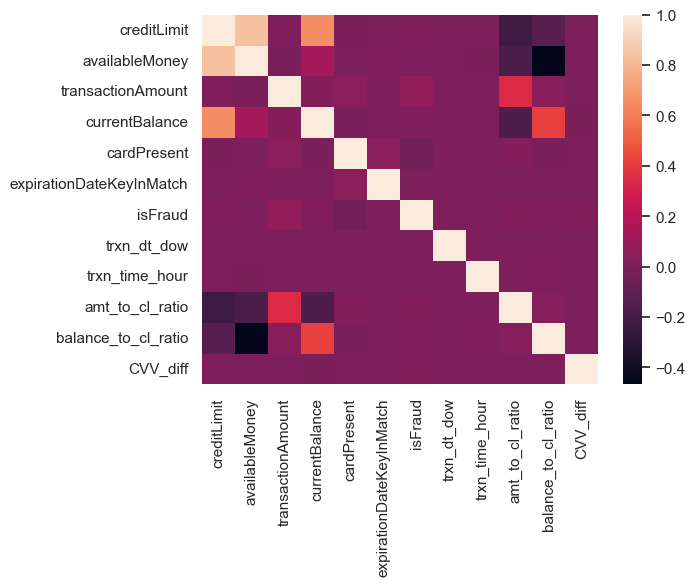

In [13]:
sns.heatmap(df.corr())

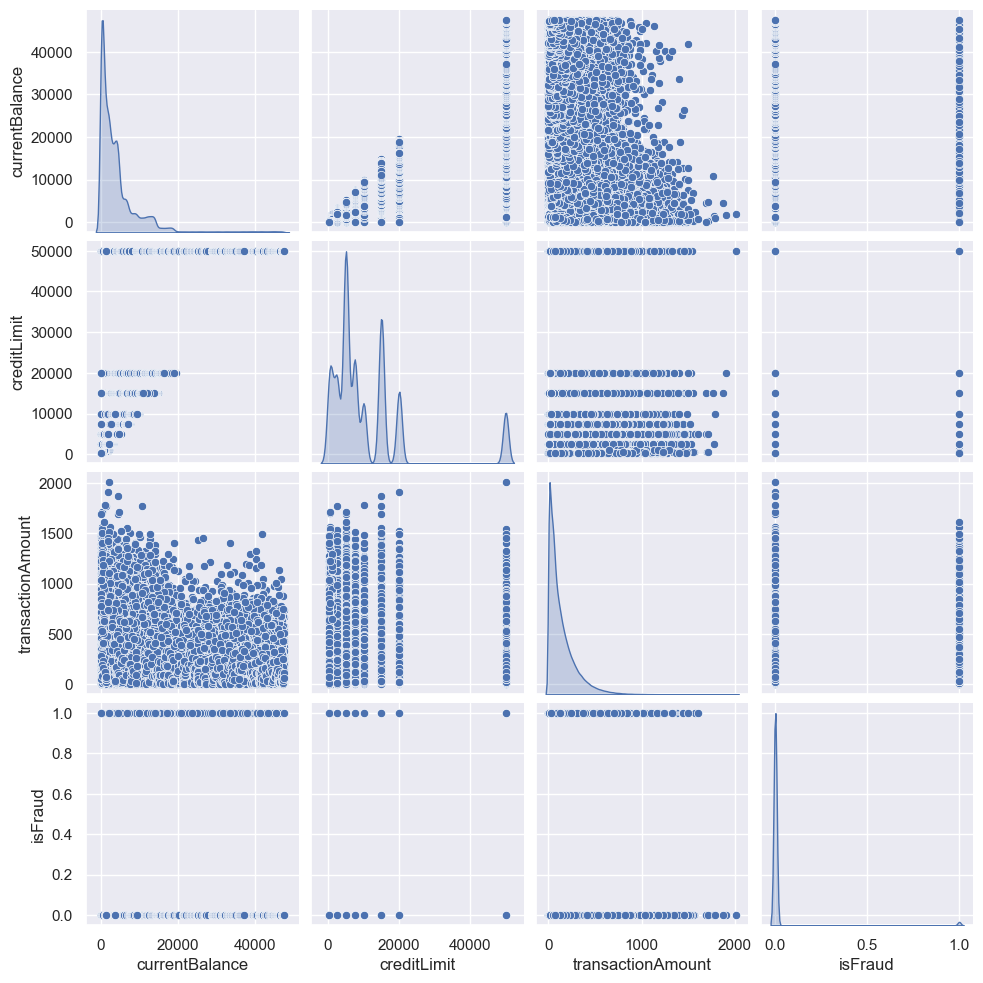

In [14]:
sns.pairplot(df.loc[:,['currentBalance', 'creditLimit','transactionAmount', 'isFraud']], diag_kind='kde')

<AxesSubplot:xlabel='isFraud', ylabel='transactionAmount'>

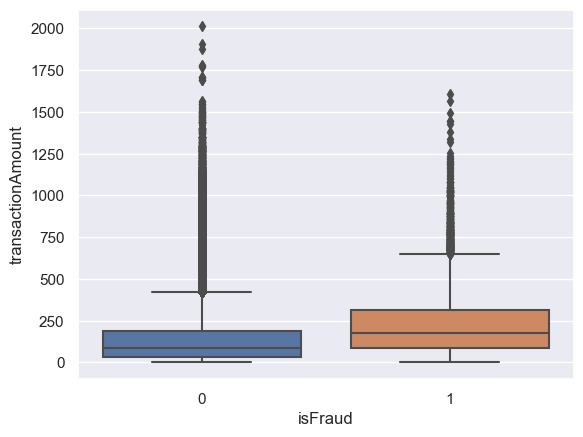

In [15]:
sns.set()
sns.boxplot(x='isFraud', y='transactionAmount', data=df)

<AxesSubplot:xlabel='isFraud', ylabel='creditLimit'>

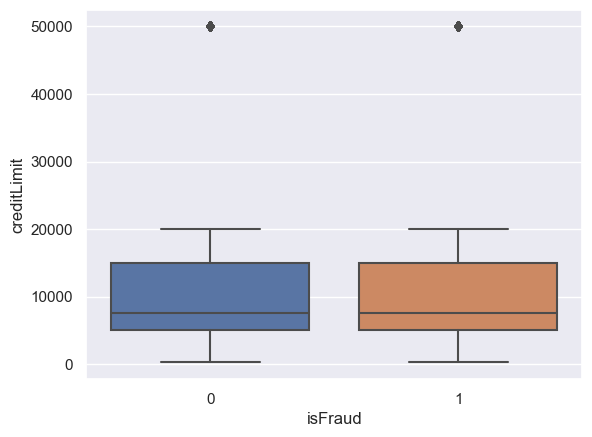

In [16]:
sns.set()
sns.boxplot(x='isFraud', y='creditLimit', data=df)

<AxesSubplot:xlabel='isFraud', ylabel='availableMoney'>

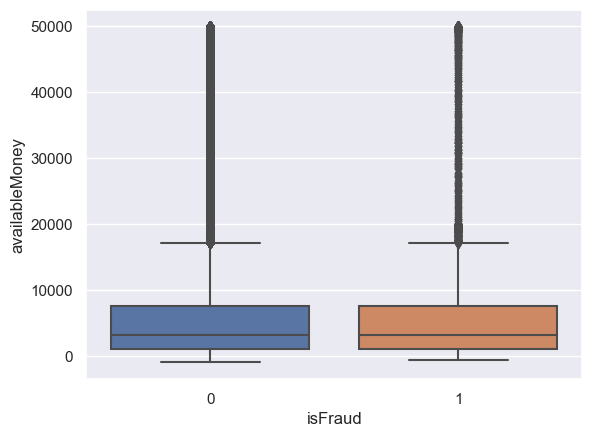

In [17]:
sns.set()
sns.boxplot(x='isFraud', y='availableMoney', data=df)

<AxesSubplot:xlabel='isFraud', ylabel='currentBalance'>

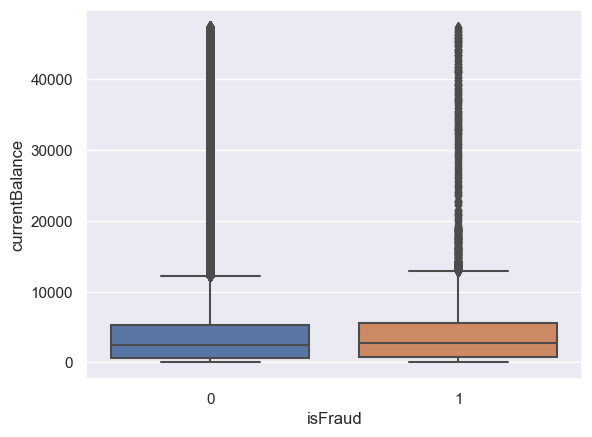

In [18]:
sns.set()
sns.boxplot(x='isFraud', y='currentBalance', data=df)

<AxesSubplot:xlabel='isFraud', ylabel='amt_to_cl_ratio'>

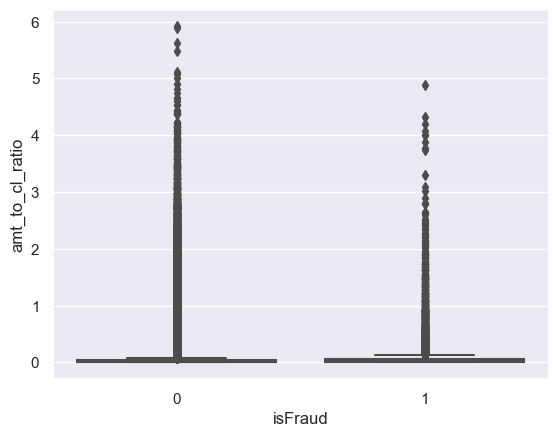

In [19]:
sns.set()
sns.boxplot(x='isFraud', y='amt_to_cl_ratio', data=df)

<AxesSubplot:xlabel='isFraud', ylabel='balance_to_cl_ratio'>

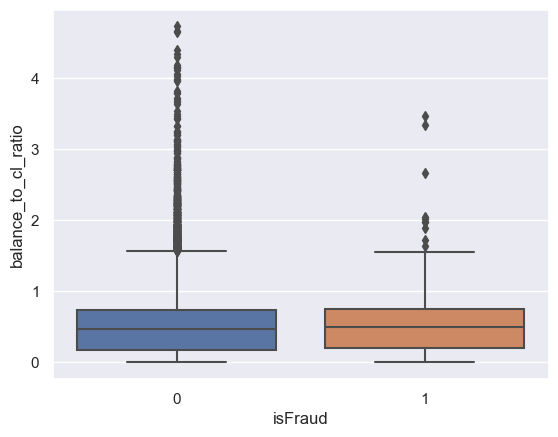

In [20]:
sns.set()
sns.boxplot(x='isFraud', y='balance_to_cl_ratio', data=df)

In [21]:
df.pivot_table(index=['trxn_dt_dow'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
trxn_dt_dow,,
0,1802,111623
1,1760,112287
2,1782,112011
3,1761,112104
4,1865,114742
5,1719,112087
6,1728,111509


In [22]:
df.pivot_table(index=['trxn_time_hour'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
trxn_time_hour,,
0,514,32854
1,482,32768
2,492,32389
3,550,32751
4,520,32689
5,496,32885
6,513,32349
7,494,32734


In [23]:
df.pivot_table(index=['transactionType'], values=['isFraud'], aggfunc=['sum','count'])


,sum,count
,isFraud,isFraud
transactionType,,
,14,698
ADDRESS_VERIFICATION,116,20169
PURCHASE,11950,745193
REVERSAL,337,20303


In [24]:
df.pivot_table(index=['merchantCategoryCode'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
merchantCategoryCode,,
airline,534,15412
auto,273,21651
cable/phone,0,1382
entertainment,961,80098
fastfood,1074,112138
food,1014,75490
food_delivery,0,6000
fuel,0,23910


In [25]:
df.pivot_table(index=['posConditionCode'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
posConditionCode,,
,22,409
01,10230,628787
08,1936,149634
99,229,7533


In [26]:
df.pivot_table(index=['CVV_diff'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
CVV_diff,,
0,12214,779348
1,203,7015


<AxesSubplot:xlabel='trxn_dt'>

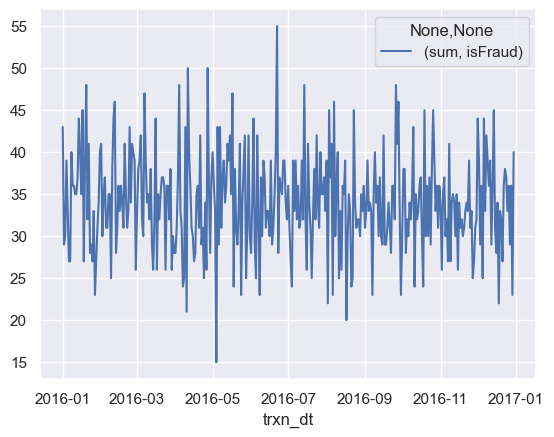

In [27]:
df.pivot_table(index=['trxn_dt'], values=['isFraud'], aggfunc=['sum']).plot()

In [28]:
#df.pivot_table(index=['transactionType'], values=['posEntryMode'], aggfunc=['sum','count'])
pd.crosstab(df.cardPresent, df.posEntryMode)

posEntryMode,,02,05,09,80,90
cardPresent,,,,,,
False,2273,107844,173749,130337,8408,10884
True,1781,88090,141286,106144,6875,8692


In [35]:
df_model.pivot_table(index=['expirationDateKeyInMatch'], values=['isFraud'], aggfunc=['sum','count'])

,sum,count
,isFraud,isFraud
expirationDateKeyInMatch,,
False,11938,744163
True,12,1030


## EDA Conclusion
### The target variable (isFraud) is imbalanced, low number of actual fraud transactions.  Will need to evaluat how to handle that in the model data prep section.  There are several variables that a correlated with each other, such as creditLimit, availableMoney, and currentBalance.  Some merchantCategoryCode values appear to differentiate between fraud more obviously than most other features.  Also, the transactionAmount median appears to be higher for fraud transnactions

## <p style="text-align: center;">Model Data Prep</p>
### In this section, we will drop all of the non-purchase transactions, hot encode categorical variables, and do a 80-20 train test split of the data.  Additionally since the data set is imbalanced, will utilize SMOTE to oversample the target variable in the training data set.  The goal here is to provide more fraud transactions to train the model with.

In [32]:
df_model = df.drop(df[df['transactionType']=='REVERSAL'].index, axis=0)
df_model.drop(df_model[df_model['transactionType']==''].index, inplace=True, axis=0)
df_model.drop(df_model[df_model['transactionType']=='ADDRESS_VERIFICATION'].index, inplace=True, axis=0)

In [33]:
#drop variables that one be needed in modeling
df_model.drop(['currentExpDate','accountOpenDate', 'dateOfLastAddressChange', 'cardCVV','enteredCVV', 'cardLast4Digits', 'accountNumber','customerId', 'merchantName', 'transactionType','trxn_dt','trxn_time'], axis=1, inplace=True)

In [36]:
transformer = make_column_transformer(
    (OneHotEncoder(), ["posConditionCode", "posEntryMode", "merchantCategoryCode","merchantCountryCode", "acqCountry" ]),
    remainder='passthrough')

transformed = transformer.fit_transform(df_model)

transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

df_model = transformed_df.copy()

C:\Users\rkiki\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
df_model.head()

,onehotencoder__x0_,onehotencoder__x0_01,onehotencoder__x0_08,onehotencoder__x0_99,onehotencoder__x1_,onehotencoder__x1_02,onehotencoder__x1_05,onehotencoder__x1_09,onehotencoder__x1_80,onehotencoder__x1_90,onehotencoder__x2_airline,onehotencoder__x2_auto,onehotencoder__x2_cable/phone,onehotencoder__x2_entertainment,onehotencoder__x2_fastfood,onehotencoder__x2_food,onehotencoder__x2_food_delivery,onehotencoder__x2_fuel,onehotencoder__x2_furniture,onehotencoder__x2_gym,onehotencoder__x2_health,onehotencoder__x2_hotels,onehotencoder__x2_mobileapps,onehotencoder__x2_online_gifts,onehotencoder__x2_online_retail,onehotencoder__x2_online_subscriptions,onehotencoder__x2_personal care,onehotencoder__x2_rideshare,onehotencoder__x2_subscriptions,onehotencoder__x3_,onehotencoder__x3_CAN,onehotencoder__x3_MEX,onehotencoder__x3_PR,onehotencoder__x3_US,onehotencoder__x4_,onehotencoder__x4_CAN,onehotencoder__x4_MEX,onehotencoder__x4_PR,onehotencoder__x4_US,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,trxn_dt_dow,trxn_time_hour,amt_to_cl_ratio,balance_to_cl_ratio,CVV_diff
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5000.0,5000.0,98.55,0.0,False,False,0,5,14,0.02,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5000.0,5000.0,74.51,0.0,True,False,0,1,5,0.015,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5000.0,5000.0,7.47,0.0,False,False,0,1,9,0.001,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5000.0,5000.0,7.47,0.0,False,False,0,5,2,0.001,0.0,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5000.0,5000.0,71.18,0.0,True,False,0,3,21,0.014,0.0,0


In [38]:
df_model.columns

Index(['onehotencoder__x0_', 'onehotencoder__x0_01', 'onehotencoder__x0_08',
       'onehotencoder__x0_99', 'onehotencoder__x1_', 'onehotencoder__x1_02',
       'onehotencoder__x1_05', 'onehotencoder__x1_09', 'onehotencoder__x1_80',
       'onehotencoder__x1_90', 'onehotencoder__x2_airline',
       'onehotencoder__x2_auto', 'onehotencoder__x2_cable/phone',
       'onehotencoder__x2_entertainment', 'onehotencoder__x2_fastfood',
       'onehotencoder__x2_food', 'onehotencoder__x2_food_delivery',
       'onehotencoder__x2_fuel', 'onehotencoder__x2_furniture',
       'onehotencoder__x2_gym', 'onehotencoder__x2_health',
       'onehotencoder__x2_hotels', 'onehotencoder__x2_mobileapps',
       'onehotencoder__x2_online_gifts', 'onehotencoder__x2_online_retail',
       'onehotencoder__x2_online_subscriptions',
       'onehotencoder__x2_personal care', 'onehotencoder__x2_rideshare',
       'onehotencoder__x2_subscriptions', 'onehotencoder__x3_',
       'onehotencoder__x3_CAN', 'onehotencoder__

In [88]:
test_vars = ['onehotencoder__x0_', 'onehotencoder__x0_01', 'onehotencoder__x0_08',
       'onehotencoder__x0_99', 'onehotencoder__x1_', 'onehotencoder__x1_02',
       'onehotencoder__x1_05', 'onehotencoder__x1_09', 'onehotencoder__x1_80',
       'onehotencoder__x1_90', 'onehotencoder__x2_airline',
       'onehotencoder__x2_auto', 'onehotencoder__x2_cable/phone',
       'onehotencoder__x2_entertainment', 'onehotencoder__x2_fastfood',
       'onehotencoder__x2_food', 'onehotencoder__x2_food_delivery',
       'onehotencoder__x2_fuel', 'onehotencoder__x2_furniture',
       'onehotencoder__x2_gym', 'onehotencoder__x2_health',
       'onehotencoder__x2_hotels', 'onehotencoder__x2_mobileapps',
       'onehotencoder__x2_online_gifts', 'onehotencoder__x2_online_retail',
       'onehotencoder__x2_online_subscriptions',
       'onehotencoder__x2_personal care', 'onehotencoder__x2_rideshare',
       'onehotencoder__x2_subscriptions', 'onehotencoder__x3_',
       'onehotencoder__x3_CAN', 'onehotencoder__x3_MEX',
       'onehotencoder__x3_PR', 'onehotencoder__x3_US', 'onehotencoder__x4_',
       'onehotencoder__x4_CAN', 'onehotencoder__x4_MEX',
       'onehotencoder__x4_PR', 'onehotencoder__x4_US', 
#       'creditLimit', 'availableMoney', #removed for better LR model and due to being highly correlated
       'transactionAmount', 
#       'currentBalance', #removed for better LR model
       'cardPresent',
       'expirationDateKeyInMatch', 'trxn_dt_dow', #'trxn_time_hour', #removed for better LR model
#       'amt_to_cl_ratio', 'balance_to_cl_ratio', #removed for better LR model
       'CVV_diff']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_model.loc[:,test_vars], df_model.loc[:,'isFraud'], test_size=.20, random_state=25)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [90]:
sm = SMOTE(random_state=25)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Modelling
### Plan to use a simple logistic regression model for baseline performance and a tree model as the challenger model.  Re-ran cells in an ad-hoc fashion for feature pruning, utilizing Logistic regression model to drop needless or correlated features.  Only model with final feature set is shown below.  Tree based model will use same set of features as Logistic Regression.  
### Target metric will be Weighted Average Precision and Recall, along with Area Under the Curve.  Will also look at the volume of false positives, since that could have a business impact of flagging too many non-fraud transactoins as being fraud having a true customer impact.


## Logistic Regression Model

In [91]:
LogReg=LogisticRegression(solver='liblinear').fit(X_train, y_train)

49338
2354
              precision    recall  f1-score   support

   not fraud       0.99      0.67      0.80    146685
       fraud       0.03      0.69      0.06      2354

    accuracy                           0.67    149039
   macro avg       0.51      0.68      0.43    149039
weighted avg       0.98      0.67      0.79    149039



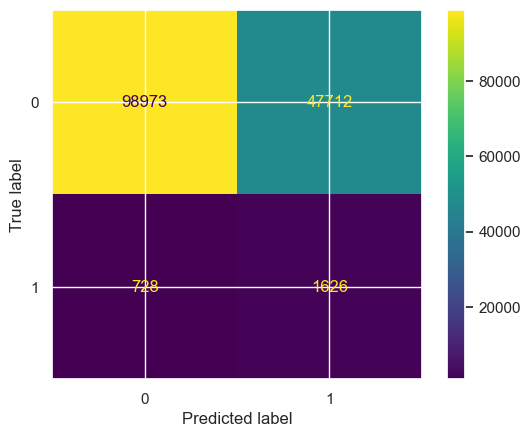

In [92]:
lr_hat = LogReg.predict(X_test)
print(sum(lr_hat))
print(sum(y_test))
target_names = ['not fraud', 'fraud']
print(classification_report(y_test, lr_hat, target_names=target_names))
#roc_auc_score(y_test, y_pred_prob) # probability of Class 1
ConfusionMatrixDisplay.from_estimator(LogReg, X_test,y_test, values_format='d')

Text(0.7, 0.2, 'AUC=0.749')

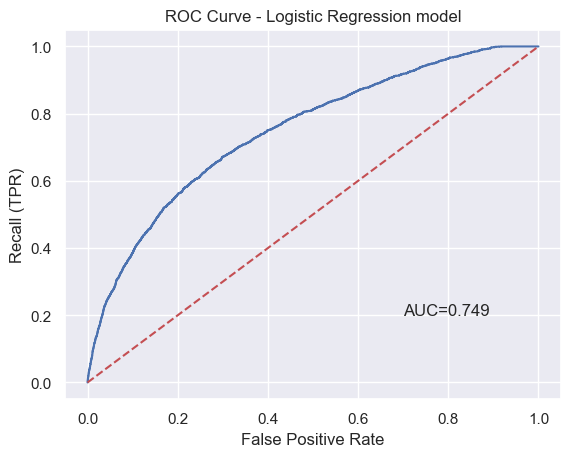

In [93]:
ypp = LogReg.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, ypp[:,1])
auc = roc_auc_score(y_test, ypp[:,1])
plt.plot(fpr,tpr,'b-')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),'r--')
plt.title('ROC Curve - Logistic Regression model')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (TPR)')
plt.text(.7,.2,'AUC='+'{:.3f}'.format(auc))

In [72]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",LogReg.coef_.transpose())

In [73]:
print(coef_table)

                                         0     Coefs
0                       onehotencoder__x0_  0.710729
1                     onehotencoder__x0_01 -0.380820
2                     onehotencoder__x0_08 -0.891670
3                     onehotencoder__x0_99 -0.176883
4                       onehotencoder__x1_  1.322479
5                     onehotencoder__x1_02 -0.151178
6                     onehotencoder__x1_05 -1.048130
7                     onehotencoder__x1_09  0.253912
8                     onehotencoder__x1_80 -0.639142
9                     onehotencoder__x1_90 -0.476586
10               onehotencoder__x2_airline  2.270416
11                  onehotencoder__x2_auto  1.352789
12           onehotencoder__x2_cable/phone -1.556510
13         onehotencoder__x2_entertainment  1.464916
14              onehotencoder__x2_fastfood  1.262759
15                  onehotencoder__x2_food  1.603168
16         onehotencoder__x2_food_delivery -2.876450
17                  onehotencoder__x2_fuel -3.

## Random Forest Classifier
### Ran a grid search to find the optimal max_depth, min_samples_split, and n_estimators
### Used same set of features as Logistic Regression model


In [94]:
rf = RandomForestClassifier(bootstrap=True, max_depth=15, min_samples_split=20, n_estimators=200,  max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=20,
                       n_estimators=200)

14066
2354
              precision    recall  f1-score   support

   not fraud       0.99      0.91      0.95    146685
       fraud       0.05      0.32      0.09      2354

    accuracy                           0.90    149039
   macro avg       0.52      0.62      0.52    149039
weighted avg       0.97      0.90      0.93    149039



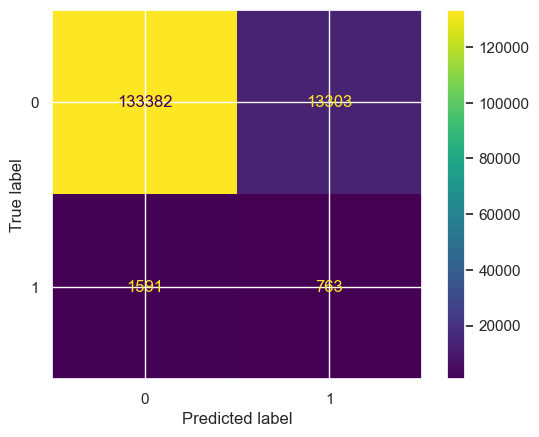

In [95]:
rf_hat = rf.predict(X_test)
print(sum(rf_hat))
print(sum(y_test))
target_names = ['not fraud', 'fraud']
print(classification_report(y_test, rf_hat, target_names=target_names))
#roc_auc_score(y_test, y_pred_prob) # probability of Class 1
ConfusionMatrixDisplay.from_estimator(rf, X_test,y_test)

Text(0.7, 0.2, 'AUC=0.717')

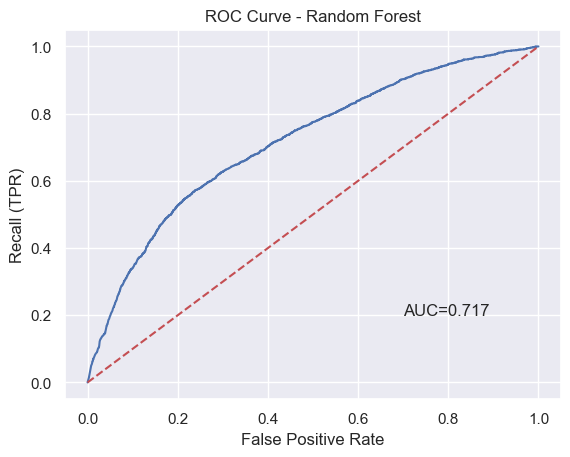

In [96]:
ypp = rf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, ypp[:,1])
auc = roc_auc_score(y_test, ypp[:,1])
plt.plot(fpr,tpr,'b-')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),'r--')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (TPR)')
plt.text(.7,.2,'AUC='+'{:.3f}'.format(auc))

## Gradient Boosting Model
### Ran a quick gradient boosting model as a comparison to the Random Forest and Logistic Regression performance

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
#gboost = GradientBoostingClassifier(learning_rate=.1, ccp_alpha= .2, n_estimators=200, subsample=.25, random_state=25)
gboost = GradientBoostingClassifier(learning_rate=.01, n_estimators=200, random_state=25, min_samples_split=100, min_samples_leaf=10)
gboost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=10,
                           min_samples_split=100, n_estimators=200,
                           random_state=25)

5246
2354
              precision    recall  f1-score   support

   not fraud       0.99      0.97      0.98    146685
       fraud       0.06      0.14      0.09      2354

    accuracy                           0.95    149039
   macro avg       0.53      0.55      0.53    149039
weighted avg       0.97      0.95      0.96    149039



C:\Users\rkiki\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


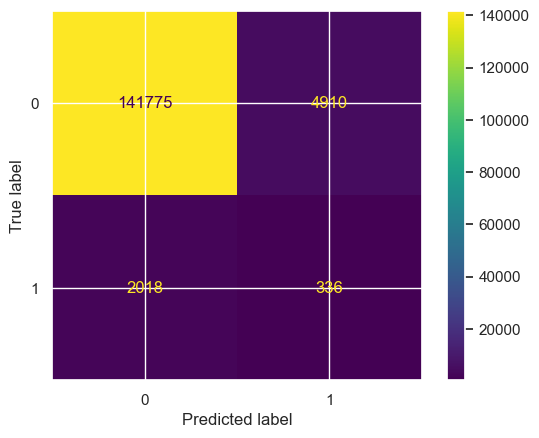

In [36]:
gb_hat = gboost.predict(X_test)
print(sum(gb_hat))
print(sum(y_test))
target_names = ['not fraud', 'fraud']
print(classification_report(y_test, gb_hat, target_names=target_names))
#roc_auc_score(y_test, y_pred_prob) # probability of Class 1
plot_confusion_matrix(gboost, X_test,y_test)

Text(0.7, 0.2, 'AUC=0.706')

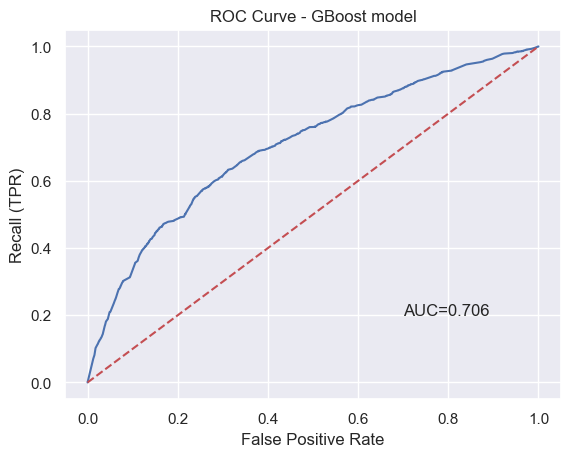

In [81]:
ypp = gboost.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, ypp[:,1])
auc = roc_auc_score(y_test, ypp[:,1])
plt.plot(fpr,tpr,'b-')
plt.plot(np.arange(0,1.1,.1),np.arange(0,1.1,.1),'r--')
plt.title('ROC Curve - GBoost model')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (TPR)')
plt.text(.7,.2,'AUC='+'{:.3f}'.format(auc))

# <p style="text-align: center;">Conclusion</p>
### The Logistic Regression model overall has a high (98%) weighted average precision and ok (67%) weighted average recall.  Taking a deeper look it had the best fraud recall (69%), but a low fraud precision rate. Resulting in a high number of false positives.  This could have a negative business impact if all of those 47k+ transactions were rejected.  Resulting in declining a third of the test transactions.
### The Random Forest model has better overall weighted averages recall (90%) and similar weighted average  precision (97%).  Taking a deeper look the fraud recall and precision and recall are worst than the logistic regression model.  However, the number of false positves drops dramatically compared to the logistic regression model.  
### A gradient boosting model was also explored, but not optimized. It has the best weight average recall (95%) and high weighted average precision (97%).  Taking a deeper look the fraud recall and precision are worst than the logistic regression model.  However, the number it has the lowest number of false positives of any of the models, though it also predicts True positives the worst. 

### My recommendation would be to use the Gradient Boosting model due to it having better weighted average recall and similar precision to the logistic regressoin and random forest.  it also has a considerably lower number of false positives that would impact non-fraudulent transactions, that could result in larger lost revenue than capturing a bit more fraud at the cost of a much higher false positive rate